In [68]:
import os
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD , Adam, RMSprop
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from numpy import load
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from sklearn.model_selection import train_test_split

In [2]:
def rename_extension(path):
  os.chdir(f'/Users/Kenechi/Artifical Intelligence/Personal Project/Competitions/ICLR/data/{path}')
  for p in os.listdir():
    p_name, p_text = (os.path.splitext(p))
    if p_text == '.jfif':
      os.rename(p, p_name + '.jpg')


In [3]:
rename_extension('train/healthy_wheat')
rename_extension('train/leaf_rust')
rename_extension('train/stem_rust')

In [4]:
image_folder = '/Users/Kenechi/Artifical Intelligence/Personal Project/Competitions/ICLR/data/train/' 

In [5]:
def mapper(analysis):
    analysis.sort() # sorts alphabetically
    # This dictionary maps labels to integers, and the reverse
    mapped_class = {analysis[i]:i for i in range(len(analysis))}
    inv_mapped_class = {i:analysis[i] for i in range(len(analysis))}
    return (mapped_class, inv_mapped_class)

In [6]:
def one_hot_encoder(value, mapped_class):
    encoding = zeros(len(mapped_class), dtype ='uint8')
    encoding[mapped_class[value]] = 1
    return encoding

In [7]:
def collect_all(directory_string):
    image_folder = listdir(directory_string)
    len_folder  = len(image_folder)
    
    print("DETAILS : ")
    print("")
    
    if len_folder > 1:
        print(f'There are {len_folder} classes in this directory :')
    elif len_folder == 1:
            print(f'There is {len_folder} class in this directory:')
    elif len_folder == 0:
            print(f'There are {len_folder} classes in this directory.')
    
    print(" ")
            
    analysis = list()       
    for sub_file in image_folder:
        sub_file_num = listdir(directory_string+sub_file) 
        print(f'{sub_file} : {len(sub_file_num)} images.')
        
        analysis.append(sub_file)
        
    mapped_class, _ = mapper(analysis)
    
    print(' ')
    
    print('Preparing data for categorical classification ...')
    
    pictures, targets = list(), list()
    for folder in image_folder:
        current_directory = listdir(directory_string + folder)
        for picture in current_directory :
            if picture != 'Thumbs.db':
                
                # load the picture
                photo = load_img(directory_string + folder + '/'+ picture, target_size =(224,224))
                
                #convert to numpy array
                photo = img_to_array(photo, dtype='uint8')  
                
                
                # one_hot_encode the targets
                target = one_hot_encoder(folder, mapped_class)
            
                # append to list
                pictures.append(photo)
                targets.append(target)
    
    X = asarray(pictures, dtype = 'uint8')
    Y = asarray(targets, dtype = 'uint8')
    
    print(' ')
    print("Done!")
    return X, Y
 # dagashi kashi  <--- download later       

In [10]:
X, Y = collect_all(image_folder)

DETAILS : 

There are 3 classes in this directory :
 
healthy_wheat : 143 images.
leaf_rust : 359 images.
stem_rust : 377 images.
 
Preparing data for categorical classification ...
 
Done!


In [11]:
print(X.shape, Y.shape)

(876, 224, 224, 3) (876, 3)


In [12]:
# save both arrays to one file in compressed format
savez_compressed('clean_data.npz', X,Y)

In [13]:
# -------------------------------------------------------------------------------------------------------------------------

In [14]:
data = load('clean_data.npz')    
X,Y = data['arr_0'], data['arr_1']
print( X.shape, Y.shape)

(876, 224, 224, 3) (876, 3)


### CNN MODEL

In [15]:
# fbeta metric
def f_beta(y_true, y_pred, beta =2):
    # clip prediction
    y_pred = backend.clip(y_pred, 0, 1)
    
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0,1)), axis = 1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0,1)), axis = 1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0,1)), axis = 1)
    
    #  precision
    p = tp / (tp + fp + backend.epsilon())
    
    #  recall
    r = tp / (tp +fn + backend.epsilon())
    
    # calculate fbeta
    
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score
    

In [16]:
def my_model(input_shape =(224,224,3), output_shape = 3):
    model = Sequential()
    model.add(Conv2D(16,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(16,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer ='he_uniform'))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01,  momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])# metrics=[f_beta])
    return model

In [17]:
def summary(info):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot (info.history['loss'], color='blue', label='train')
    plt.plot (info.history['val_loss'], color='orange', label='test')
    plt.legend(["Loss","Validation Loss"])
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot (info.history['accuracy'], color='blue', label='train')
    plt.plot (info.history['val_accuracy'], color='orange', label='test')
    plt.legend(["Accuracy","Validation Accuracy"])
    

In [18]:
def load_split_dataset(X,Y):
    train_x, test_x,train_y,test_y = train_test_split(X, Y, test_size = 0.2, random_state =3)
    print(train_x.shape, test_x.shape,train_y.shape,test_y.shape)
    return(train_x, test_x, train_y, test_y)

In [19]:
def run_learning_sequence(X,Y):
    # load dataset
    train_x, test_x,train_y,test_y = load_split_dataset(X, Y)
    
    #create data generator
    train_datagen = ImageDataGenerator(rescale =1.0/255.0,  horizontal_flip = True, vertical_flip = True, rotation_range = 90)
    val_datagen = ImageDataGenerator(rescale =1.0/255.0)
    
    # prepare iterations
    train = train_datagen.flow(train_x, train_y, batch_size = 32)
    val = val_datagen.flow(test_x, test_y, batch_size = 32)
        
    # define the model
    model = my_model()
    
    # fitting the model
    info = model.fit_generator(train, steps_per_epoch = 90, validation_data = val,       #steps_per_epoch = len(train), validation_steps = len(val)
                                 validation_steps = 15, epochs = 120, verbose = 1) # or steps_per_epoch = 879/30 => 29.3
                                                                                        # round up or round down, you decide.
                                                                                        # 879 is the total number of images
                                                                                        # in the train dataset, and 30 is the
                                                                                        # batch_size declared in train_datagen.flow()
    
    # evaluate the model                                                                # steps = len(val)              
    loss, accuracy = model.evaluate_generator(val, steps = 15, verbose = 0)
    print('> loss = %.3f, accuracy=%.3f' %(loss, accuracy))
    
     # saving the model
    model.save('GREEN_model.h5')
    
    # display learning curves
    summary(info)

(700, 224, 224, 3) (176, 224, 224, 3) (700, 3) (176, 3)
Epoch 1/120
90/90 [==============================] - 3973s 44s/step - loss: 1.3990 - accuracy: 0.4190 - val_loss: 1.2156 - val_accuracy: 0.3951
Epoch 2/120
90/90 [==============================] - 372s 4s/step - loss: 1.0226 - accuracy: 0.4260 - val_loss: 1.1731 - val_accuracy: 0.3611
Epoch 3/120
90/90 [==============================] - 370s 4s/step - loss: 1.0153 - accuracy: 0.4305 - val_loss: 1.0177 - val_accuracy: 0.4777
Epoch 4/120
90/90 [==============================] - 372s 4s/step - loss: 1.0045 - accuracy: 0.4483 - val_loss: 0.9330 - val_accuracy: 0.4097
Epoch 5/120
90/90 [==============================] - 369s 4s/step - loss: 0.9619 - accuracy: 0.4668 - val_loss: 0.8976 - val_accuracy: 0.4018
Epoch 6/120
90/90 [==============================] - 371s 4s/step - loss: 0.8861 - accuracy: 0.5248 - val_loss: 1.1288 - val_accuracy: 0.5185
Epoch 7/120
90/90 [==============================] - 371s 4s/step - loss: 0.8969 - accurac

Epoch 58/120
90/90 [==============================] - 369s 4s/step - loss: 0.3439 - accuracy: 0.8577 - val_loss: 1.8085 - val_accuracy: 0.7153
Epoch 59/120
90/90 [==============================] - 371s 4s/step - loss: 0.3359 - accuracy: 0.8560 - val_loss: 1.7291 - val_accuracy: 0.7143
Epoch 60/120
90/90 [==============================] - 368s 4s/step - loss: 0.3377 - accuracy: 0.8603 - val_loss: 1.2113 - val_accuracy: 0.7245
Epoch 61/120
90/90 [==============================] - 680s 8s/step - loss: 0.3413 - accuracy: 0.8638 - val_loss: 1.0226 - val_accuracy: 0.6674
Epoch 62/120
90/90 [==============================] - 11925s 132s/step - loss: 0.3371 - accuracy: 0.8598 - val_loss: 1.2716 - val_accuracy: 0.6875
Epoch 63/120
90/90 [==============================] - 383s 4s/step - loss: 0.3265 - accuracy: 0.8610 - val_loss: 1.0840 - val_accuracy: 0.7210
Epoch 64/120
90/90 [==============================] - 370s 4s/step - loss: 0.3135 - accuracy: 0.8715 - val_loss: 1.4461 - val_accuracy: 0.

90/90 [==============================] - 957s 11s/step - loss: 0.1425 - accuracy: 0.9434 - val_loss: 1.2679 - val_accuracy: 0.7076
Epoch 116/120
90/90 [==============================] - 954s 11s/step - loss: 0.1678 - accuracy: 0.9400 - val_loss: 0.3872 - val_accuracy: 0.6991
Epoch 117/120
90/90 [==============================] - 968s 11s/step - loss: 0.1712 - accuracy: 0.9311 - val_loss: 1.1115 - val_accuracy: 0.6674
Epoch 118/120
90/90 [==============================] - 956s 11s/step - loss: 0.1077 - accuracy: 0.9595 - val_loss: 1.7550 - val_accuracy: 0.6968
Epoch 119/120
90/90 [==============================] - 933s 10s/step - loss: 0.1466 - accuracy: 0.9459 - val_loss: 1.2705 - val_accuracy: 0.7165
Epoch 120/120
90/90 [==============================] - 914s 10s/step - loss: 0.1578 - accuracy: 0.9399 - val_loss: 1.4612 - val_accuracy: 0.6782
> loss = 1.690, accuracy=0.665


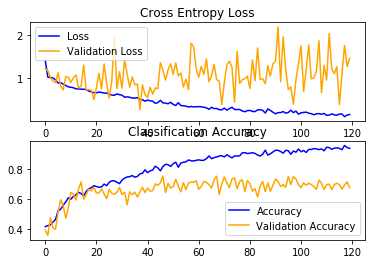

In [21]:
run_learning_sequence(X,Y)

### PREDICTIONS

In [24]:
directory_string = '/Users/Kenechi/Artifical Intelligence/Personal Project/Competitions/ICLR/data/train/' 

In [25]:
analysis = list()
image_folder = listdir(directory_string)
for sub_file in image_folder:
    analysis.append(sub_file)
        
_, inv_mapped_class = mapper(analysis)

In [26]:
inv_mapped_class

{0: 'healthy_wheat', 1: 'leaf_rust', 2: 'stem_rust'}

In [62]:
def prediction_to_labels(inv_mapping, prediction):
    value  = prediction.round()
    # convert to predicted tags
    labels = [inv_mapping[i] for i in range(len(value)) if value[i] == 1.0]
    return labels

In [ ]:
# The approach I would take is to convert all the test images into a numpy array.

In [40]:
test_string = '/Users/Kenechi/Artifical Intelligence/Personal Project/Competitions/ICLR/test/'

In [57]:
def load_new_image(directory):
    test_pictures = list()
    print(' Converting to numpy array ...')
    for picture in listdir(directory) :
         if picture != 'Thumbs.db':
                 # load the picture
                photo = load_img(directory + picture, target_size = (224,224))
                
                #convert to numpy array
                photo = img_to_array(photo, dtype='uint8')  
                
                photo = photo.reshape(1, 224, 224, 3)
                
                 # append to list
                test_pictures.append(photo)
                
    X_TEST = asarray(test_pictures, dtype = 'uint8')  
    print(' ')
    print('Done!')
    return X_TEST 

In [58]:
X_TEST = load_new_image(test_string)

 Converting to numpy array ...
 
Done!


In [59]:
len(X_TEST)

610

In [63]:
def run_prediction_sequence(X_TEST, inv_mapped_class):
    # load model
    model = load_model('/Users/Kenechi/Artifical Intelligence/Personal Project/Competitions/ICLR/GREEN_model.h5')
    
    # predict the class
    for i in range(len(X_TEST)):
        result = model.predict((X_TEST[i]))
        #print(result[0])
        # map predictions to tags
        label = prediction_to_labels(inv_mapped_class, result[0])
        print(label)                       
    
    

In [64]:
run_prediction_sequence(X_TEST, inv_mapped_class)

['healthy_wheat']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['stem_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['stem_rust']
['healthy_wheat']
['stem_rust']
['healthy_wheat']
['stem_rust']
['stem_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['leaf_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['healthy_wheat']
['leaf_rust']
['healthy_wheat']
['stem_rust']
['stem_rust']
['leaf_rust']
['healthy_wheat']
['stem_rust']
['healthy_wheat']
['leaf_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['leaf_rust']
['leaf_rust']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['stem_rust']


['healthy_wheat']
['stem_rust']
['stem_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['leaf_rust']
['stem_rust']
['leaf_rust']
['healthy_wheat']
['leaf_rust']
['healthy_wheat']
['stem_rust']
['stem_rust']
['healthy_wheat']
['stem_rust']
['stem_rust']
['healthy_wheat']
['leaf_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['leaf_rust']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['stem_rust']
['healthy_wheat']
['stem_rust']
['stem_rust']
['stem_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['healthy_wheat']
['stem_rust']
['healthy_wheat']
['leaf_rust']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['stem_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['leaf_rust']
['stem_rust']
['healthy_wheat']
['stem_rust']
['healthy_wheat']
['healthy_wheat']
['stem_rust']
['leaf_rust']
['stem_rust']
['heal

### Comparing the prediction to the images, looks like model performed well.